# Light curve minima fitter and O-C calculator

As shape of the minimum of pulsating stars varies by time, each minimum is fitted by a function individually in a given phase interval.

Errors are estimate with brute force, i.e. resampling observations n times with known observational errors.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar
import glob
from matplotlib.backends.backend_pdf import PdfPages
from astropy.convolution.kernels import Box1DKernel, Gaussian1DKernel
from astropy.convolution import convolve
import pandas as pd
import collections
from joblib import Parallel, delayed
import warnings
import subprocess
from astroquery.vizier import Vizier
from tqdm import tqdm
try:
    from statsmodels.nonparametric.kernel_regression import KernelReg
except ModuleNotFoundError:
    print('No module named: statsmodels')
    print('Install it, otherwise only polynomial can be fit!')
    
from scipy.stats import binned_statistic
from scipy.optimize import minimize

def get_model(lc,period,phase=0,show_plot=False):
    times = lc[:,0].copy()
    zero_time = np.floor(times[0])
    times -= zero_time

    flux = lc[:,1].copy()
    corrflux = flux.copy()
    
    lcmean = np.mean(flux) - np.ptp(flux)/2

    # Loop over each cycle and shift them vertically to match each other
    i = 0
    while True:
        um = np.where(( i*period <= times) & (times < period + i*period)  )[0]

        if len(um)==0:
            if i*period > times.max():
                break
            else:
                i += 1
                continue
        corrflux[um] -= corrflux[um].min()
        corrflux[um] += lcmean
        i += 1

        if i*period > times.max():
            break
    
    # Shift minimum to middle of the phase curve
    times -= phase
    times += period/2
    
    # Bin phase shifted phase curve
    ybinned,xbinned,_ = binned_statistic(times%period,corrflux,statistic='median', bins=100, range=(0,period))
    xbinned = (xbinned[1:] + xbinned[:-1])/2
    
    xbinned += phase
    xbinned -= period/2
    
    goodpts = np.where( np.isfinite(ybinned) )[0]
    xbinned = xbinned[goodpts]
    ybinned = ybinned[goodpts]
    
    # Get model fit
    ksrmv = KernelReg(endog=ybinned, exog=xbinned, var_type='c',
                      reg_type='ll', bw=np.array([0.02]) )
    pol = lambda x : ksrmv.fit(np.atleast_1d(x))[0][0] if isinstance(x,float) else ksrmv.fit(np.atleast_1d(x))[0]
    
    if show_plot:
        phasetoplot = times%period +phase -period/2
        
        plt.figure(figsize=(8,5))
        plt.title('Light curve model to be shifted to each minimum\nGray:original Black:y shifted Blue:binned Orange:model')
        plt.plot( phasetoplot, flux , '.', c='lightgray')
        plt.plot( phasetoplot, corrflux , 'k.')
        plt.plot(xbinned,ybinned,'.')
        plt.plot( np.linspace(phasetoplot.min(),phasetoplot.max(),100),pol(np.linspace(phasetoplot.min(),phasetoplot.max(),100)) )
        plt.xlabel('Cycle (= one period)')
        plt.ylabel('Brightness')
        plt.show()

    return pol , phase

def chi2model(params,x,y,sig,pol):
    xoffset = params[0]
    yoffset = params[1]
    model = pol(x + xoffset) + yoffset
    chi2 = (np.power(y - model,2) / (sig**2)).sum()
    
    return chi2
    
def get_VSX(name):
    """
    Query VSX for RA, DEC, Period
    """
    print('Querying VSX...')
    res = Vizier.query_object(name,catalog='B/vsx/vsx')

    try:
        RA = res[0]['RAJ2000'].tolist()[0]
        DEC = res[0]['DEJ2000'].tolist()[0]
        period = res[0]['Period'].tolist()[0]
    except IndexError:
        raise NameError('Star %s not found in VSX! Please pass period manually.' % name)

    print('Returned RA DEC Period')
    print(RA,DEC,period)

    return RA,DEC,period

def JD2BJD(JD,RA,DEC):
    """
    Convert JD to Barycentric JD
    """
    
    print('Converting JD to BJD...')
    
    '''# Using fitsh
    np.savetxt('test_JD.txt',JD)

    cmd = "cat test_JD.txt | lfit -c JD -f 'bjd(JD,"+str(RA)+","+str(DEC)+")' -F '%.8f'"
    process = subprocess.Popen(cmd,shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = process.communicate()

    subprocess.call(['rm','test_JD.txt']);

    out = out.decode('utf-8')
    out = np.array([row.split() for i,row in enumerate(out.split('\n')) if i < len(out.split('\n'))-1 ])
    out = out.reshape(out.shape[0]).astype('float')
    '''
    
    from astropy.time import Time
    from astropy.units import deg, m as meter
    from astropy.coordinates import SkyCoord, EarthLocation

    times = Time(JD, format='jd', scale='utc')
    sc = SkyCoord(ra=RA*deg, dec=DEC*deg)
    loc = EarthLocation.from_geodetic(lat=0*deg, lon=0*deg, height=0*meter)
    ltt_bary = times.light_travel_time(sc,location=loc)
    bjd = times.tdb + ltt_bary
    bjd = bjd.value
    
    return bjd

def load_sectors(name,suffix,usecols=(0,1,2)):
    """
    Load all files associated with a given star
    """
    print('Loading data...')
    for i,field in enumerate( sorted(glob.glob(name+suffix)) ):
        if "OC.txt" in field: continue
            
        if i==0:
            lc = np.loadtxt('%s' % field, usecols=usecols)
        else:
            lc = np.vstack((lc, np.loadtxt('%s' % field, usecols=usecols)  ))

    try:
        lc = lc[ np.isfinite(lc[:,0]) ]
        lc = lc[ np.isfinite(lc[:,1]) ]
        lc = lc[ np.isfinite(lc[:,2]) ]
        lc = lc[lc[:,0].argsort()]
    except UnboundLocalError:
        raise FileNotFoundError('No files found starts with name %s and ends with suffix %s' % (name,suffix))
        
    return lc

def split_data_by_gaps(data):
    print('Splitting data by gaps...')
    df = pd.DataFrame(data)
    median_diff = np.nanmedian(df[0].diff())
    diffs= df[0].diff() > 10.*median_diff
    labels = diffs.apply(lambda x: 1 if x else 0).cumsum()
    data = np.column_stack((data,labels))

    counter=collections.Counter(labels)
    splits = counter.keys()

    return data,splits

def sigma_clipping(time,mag,sigma,err=None,showplot=False,showsteps=False,kernel='Gaussian',width=0.1):
    """
    Sigma clipping by smoothing using a selected kernel
    Kernels:
        Median, Box, Gaussian
    """
    print('Sigma clipping...')
    if showplot or showsteps:
        time_in = time.copy()
        mag_in = mag.copy()

    if kernel=='Median':
        smoothed_signal_g = [np.median(mag) for i in mag]

    if kernel=='Box':
        smooth_width_g = width/((time[-1]-time[0])/len(time))
        smoothed_signal_g = convolve(mag, Box1DKernel(smooth_width_g),boundary="extend")

    if kernel=='Gaussian':
        smooth_width_g = width/((time[-1]-time[0])/len(time))
        smoothed_signal_g = convolve(mag, Gaussian1DKernel(smooth_width_g),boundary="extend")

    #plt.plot(time,mag,'ko')
    #plt.plot(time,smoothed_signal,'r')
    #plt.plot(time,smoothed_signal_g,'g')
    #plt.show()

    while True:
        if showsteps:
            plt.plot(time,mag,'ko',label='Original data')
            #plt.plot(time,smoothed_signal,'r')
            plt.plot(time,smoothed_signal_g,'g',label='Smooth')
            plt.suptitle('Cleaning in progress...')
            plt.xlabel('Time')
            plt.ylabel('Brightness')
            plt.legend()
            plt.show()

        residual = mag-smoothed_signal_g
        upper_limit = np.mean(residual)+sigma*np.std(residual)
        lower_limit = np.mean(residual)-sigma*np.std(residual)

        if showsteps:
            plt.plot(time,residual,'ko',label='Residual data')
            plt.axhline(upper_limit,label='Upper/lower clipping limit')
            plt.axhline(lower_limit,label='__nolegend__')
            plt.suptitle('Cleaning in progress...')
            plt.xlabel('Time')
            plt.ylabel('Brightness')
            plt.legend()
            plt.show()

        um = np.where( (lower_limit<=residual) & (residual<=upper_limit) )[0]
        prev_number_of_points = len(time)
        time = time[um]
        mag = mag[um]
        if err is not None:
            err = err[um]

        if len(time) == prev_number_of_points:
            break

        if kernel=='Median':
            smoothed_signal_g = [np.median(mag) for i in mag]

        if kernel=='Box':
            smooth_width_g = width/((time[-1]-time[0])/len(time))
            smoothed_signal_g = convolve(mag, Box1DKernel(smooth_width_g),boundary="extend")

        if kernel=='Gaussian':
            smooth_width_g = width/((time[-1]-time[0])/len(time))
            smoothed_signal_g = convolve(mag, Gaussian1DKernel(smooth_width_g),boundary="extend")

    if showplot:
        umdroped = np.arange(len(time_in))
        umdrop = np.delete(umdroped,um)
        
        plt.figure(figsize=(12,4))
        plt.suptitle('Cleaned data | black:original red:outlier')
        plt.plot(time_in,mag_in,'ko')
        plt.plot(time_in[umdrop],mag_in[umdrop],'ro')
        plt.xlabel('Time')
        plt.ylabel('Brightness')
        plt.show()

    if err is not None:
        return time,mag,err
    else:
        return time,mag

def neglogL(x,y,sig,model,model_params=None):
    """
    Chi2 negative logLikelihood (to be minimised)
    """
    n = len(y)
    if model_params is not None:
        L = ( n/2.*np.log(2*np.pi*sig**2) - ((y-model(x,model_params))**2)/(2*sig**2) ).sum()
    else:
        L = ( n/2.*np.log(2*np.pi*sig**2) - ((y-model(x))**2)/(2*sig**2) ).sum()
    return -L

def mintime_parallel(params):
    """
    Refit minima with generating new observations from noise
    """
    fittype = params[-1]
    if fittype=='model':
        x,y,err,pol,zero_time,x0,y0 = params[:7]
        phaseoffset,i,period = params[7:-1]
    else:
        x,y,order,zero_time = params[:4]
        bound1, bound2 = params[4:-1]

    if fittype=='nonparametric':
        ksrmv = KernelReg(endog=y, exog=x, var_type='c',
                          reg_type='ll', bw=np.array([np.median(np.diff(x))]) )
        p_fit = lambda x : ksrmv.fit(np.atleast_1d(x))[0][0] if isinstance(x,float) else ksrmv.fit(np.atleast_1d(x))[0]
    
        result = minimize_scalar(p_fit, bounds=(bound1, bound2), method='bounded')
        t = result.x + zero_time
    elif fittype=='model':
        res = minimize(chi2model, (x0,y0), args=(x,y,err,pol) ,
                       method='Powell')

        #yoffset = res.x[1]
        xoffset = res.x[0]

        t = zero_time +phaseoffset +(i-1)*period -xoffset
    else:
        with warnings.catch_warnings(record=True):
            y_model = np.polyfit(x,y,order)
            p_fit = np.poly1d(y_model)
    
        result = minimize_scalar(p_fit, bounds=(bound1, bound2), method='bounded')
        t = result.x + zero_time
    
    return t

def calculate_mintimes(name,lc,period,
                       fittype='poly',
                       phase_interval=0.1,
                       order=3,smoothness=1,
                       npools=1,samplings=100000,
                       showplot=False,saveplot=True,showfirst=True,
                       debug=False):
    """
    Fit minima(!) one by one.
    
    Parameters
    ----------
    name : str
        Filename to be used.
    lc : array
        Light curve data.
    period : float
        Period of given variable star.
    fittype : 'poly', 'nonparametric' or 'model'.
        The type of the fitted function.
    phase_interval : float
        The phase interval around expected minima, which is
        used to fit a function.
    order : int
        Order of the polynomial to be fitted to each minimum.
        Applies only if `fittype` is `poly`.
    smoothness : float
        The smoothness of fitted nonparametric function.
        Use ~1, to follow small scale variations. Use >1
        to fit really smooth function.
        Applies only if `fittype` is `nonparametric`.
    npools : int
        Number of cores during error estimation.
    samplings : int
        Number of resamplings for error estimation.
    showplot : bool
        Show all plots.
    saveplot : bool
        Save all plots.
    showfirst : bool
        Show epoch and first fit to check parameters.
    """
    
    if fittype not in ['poly','nonparametric','model']:
        raise NameError('Fittype is not known! Use \'poly\', \'nonparametric\' or \'model\'.')
    
    print('Calculating minima times...')
    if saveplot: pp = PdfPages(name+'_minima_fit.pdf')

    x = lc[:,0]
    y = lc[:,1]
    err = lc[:,2]
    cadence = np.median(np.diff(x))
    
    # List to store times of minima
    mintimes = [] 

    #####################################
    # Fit first cycle to estimate epoch #
    #####################################
    umcycle = np.where(x<x[0]+period)[0]
    um2 = np.argmin( y[umcycle] )

    # If very first point is the min, extend phase interval
    if um2 == 0:
        umcycle = np.where(x<x[0]+1.3*period)[0]
        um2 = np.argmin( y[umcycle] )
        
        mean_t = x[umcycle][um2]
    else:
        mean_t = x[umcycle][um2]
    
    zero_time = np.floor(x[0])
    
    # Fit the data within this phase interval
    pm = period*0.1 #days
    
    um=np.where((mean_t-pm<x) & (x<=mean_t+pm)  )[0]

    if fittype=='nonparametric':
        ksrmv = KernelReg(endog=y[um], exog=x[um]-zero_time, var_type='c',
                          reg_type='ll', bw=np.array([np.median(np.diff(x[um]))]) )
        p = lambda x : ksrmv.fit(np.atleast_1d(x))[0][0] if isinstance(x,float) else ksrmv.fit(np.atleast_1d(x))[0]
    else:
        with warnings.catch_warnings(record=True):
            z = np.polyfit(x[um]-zero_time, y[um], 3)
        p = np.poly1d(z)

    result = minimize_scalar(p, bounds=(mean_t-zero_time-pm, mean_t-zero_time+pm), method='bounded')
    mean_t = result.x + zero_time
        
    if showplot or showfirst:
        plt.scatter(x[umcycle],y[umcycle],c='k',label='First cycle')
        plt.axvline( mean_t, c='r',label='Epoch',zorder=0 )
        plt.xlabel('Time')
        plt.ylabel('Brightness')
        plt.suptitle(name)
        plt.legend()
        plt.show()
    
    #######################################
    # Fit each cycle to get minimum times #
    #######################################
    
    # Initialize progress bar
    pbar = tqdm()
    
    # Range to be fitted around the expected minimum:
    pm = period*phase_interval #days
    
    if fittype=='model':
        pol,phaseoffset = get_model(lc,period,phase=mean_t-zero_time,
                                    show_plot=showfirst or showplot)

    i=1 #First minimum
    firstmin = True
    while True:
        # If duty cycle is lower than 20% do not fit
        dutycycle = 0.2
        um = np.where((mean_t-pm<x) & (x<=mean_t+pm)  )[0]        
        if len(x[um])<(pm/cadence*dutycycle):
            mean_t = mean_t + period
            i=i+1
            if mean_t> np.max(x):
                break
            else:
                continue

        ###################################################
        # First fit the data around expected minimum time #
        ###################################################
        if fittype=='nonparametric':
            ksrmv = KernelReg(endog=y[um], exog=x[um]-zero_time, var_type='c',
                              reg_type='ll', bw=np.array([np.median(np.diff(x[um]))]) )
            p = lambda x : ksrmv.fit(np.atleast_1d(x))[0][0] if isinstance(x,float) else ksrmv.fit(np.atleast_1d(x))[0]
        
            result = minimize_scalar(p, bounds=(mean_t-zero_time-pm, mean_t-zero_time+pm), method='bounded')
            t_initial = result.x + zero_time
        elif fittype=='model':
            with warnings.catch_warnings(record=True):
                y0 = np.mean(y[um]) - np.mean(pol(x[um]-zero_time -(i-1)*period))
                x0 = 0
                res = minimize(chi2model, (x0,y0),
                               args=(x[um]-zero_time -(i-1)*period , y[um],err[um],pol),
                               method='Powell')
                               #bounds=((-period/2,period/2),(-np.inf,np.inf)))

            yoffset = res.x[1]
            xoffset = res.x[0]

            t_initial = zero_time +phaseoffset +(i-1)*period -xoffset
            
            if debug:
                plt.title('First fit')
                plt.plot(x[um],y[um],'.')
                xtobeplotted = np.linspace( x[um].min(),x[um].max(), 1000 )
                plt.plot(xtobeplotted,pol(xtobeplotted-zero_time-(i-1)*period+x0 ) + y0 ,'r',label='Initial')
                plt.plot(xtobeplotted,pol(xtobeplotted-zero_time-(i-1)*period + xoffset) + yoffset,'k',label='Final fit')
                plt.axvline(t_initial,c='r')
                plt.xlim(x[um][0],x[um][-1])
                #plt.ylim(y[um].min() - 0.1*y[um].ptp(), y[um].max() + 0.1*y[um].ptp() )
                plt.legend()
                plt.show()
                plt.close('all')
        else:
            with warnings.catch_warnings(record=True):
                z = np.polyfit(x[um]-zero_time, y[um], order)
            p = np.poly1d(z)
            
            result = minimize_scalar(p, bounds=(mean_t-zero_time-pm, mean_t-zero_time+pm), method='bounded')
            t_initial = result.x + zero_time


        # Continue if duty cycle is lower than 20%
        um = np.where((t_initial-pm<x) & (x<=t_initial+pm)  )
        um_before = np.where((t_initial-pm<x) & (x<=t_initial)  )
        um_after  = np.where((t_initial<x) & (x<=t_initial+pm)  )
        if len(x[um_before])<(pm/cadence*dutycycle) or len(x[um_after])<(pm/cadence*dutycycle):
            mean_t = mean_t + period
            i=i+1
            continue

        ########################################################
        # Second fit the data again around fitted minimum time #
        ########################################################
        if fittype=='nonparametric':
            ksrmv = KernelReg(endog=y[um], exog=x[um]-zero_time, var_type='c',
                              reg_type='ll', bw=smoothness*np.array([np.median(np.diff(x[um]))]) )
            p = lambda x : ksrmv.fit(np.atleast_1d(x))[0][0] if isinstance(x,float) else ksrmv.fit(np.atleast_1d(x))[0]
        
            result = minimize_scalar(p, bounds=(t_initial-zero_time-pm, t_initial-zero_time+pm), method='bounded')
            t = result.x + zero_time
        elif fittype=='model':
            with warnings.catch_warnings(record=True):
                y0 = yoffset
                x0 = xoffset
                res = minimize(chi2model, (x0,y0), 
                               args=(x[um]-zero_time-(i-1)*period , y[um],err[um],pol),
                               method='Powell')
                               #bounds=((-period/2,period/2),(-np.inf,np.inf)))

            yoffset = res.x[1]
            xoffset = res.x[0]

            t = zero_time +phaseoffset +(i-1)*period -xoffset
            
            if debug:
                plt.title('Second fit')
                plt.plot(x[um],y[um],'.')
                xtobeplotted = np.linspace( x[um].min(),x[um].max(), 1000 )
                plt.plot(xtobeplotted,pol(xtobeplotted-zero_time-(i-1)*period +x0)+y0 ,label='Initial')
                plt.plot(xtobeplotted,pol(xtobeplotted-zero_time-(i-1)*period + xoffset) + yoffset ,label='Final fit')
                plt.axvline(t,c='r')
                plt.legend()
                plt.show()
                plt.close('all')
        else:
            with warnings.catch_warnings(record=True):
                z = np.polyfit(x[um]-zero_time, y[um], order)
            p = np.poly1d(z)

            result = minimize_scalar(p, bounds=(t_initial-zero_time-pm, t_initial-zero_time+pm), method='bounded')
            t = result.x + zero_time

        #######################
        # Stopping conditions #
        #######################
        # Break if the data is over
        if mean_t> np.max(x):
            break

        # Continue if the number of points is low (duty cycle is lower than 20%)
        um_before = np.where((t-pm<x) & (x<=t)  )
        um_after = np.where((t<x) & (x<=t+pm)  )
        if len(x[um_before])<(pm/cadence*0.2) or len(x[um_after])<(pm/cadence*0.2) or len(x[um])<(pm/cadence*0.2):
            mean_t = mean_t + period
            i=i+1
            continue
            
        # Continue if fit is not a minimum
        first_point = y[um][0]
        last_point = y[um][-1]
        middle_point = np.min(y[um][1:-1])
        if not (middle_point<=first_point and middle_point<=last_point):
            mean_t = mean_t + period
            i=i+1
            continue

        ###########################################################
        # Calculate error by sampling from y errors and refitting #
        ###########################################################
        z_fit_parallel = []
        if fittype=='model':
            for _ in range(samplings):
                y_resampled = y[um] + np.random.normal(loc=0,scale=err[um],size=err[um].shape[0])
                z_fit_parallel.append([x[um]-zero_time-(i-1)*period, y_resampled, err[um], pol, zero_time, 
                                       xoffset, yoffset, phaseoffset, i, period, fittype ])
        else:
            for _ in range(samplings):
                y_resampled = y[um] + np.random.normal(loc=0,scale=err[um],size=err[um].shape[0])
                z_fit_parallel.append([x[um]-zero_time, y_resampled, order, zero_time, t-zero_time-pm, t-zero_time+pm , fittype ])
        
        t_trace = Parallel(n_jobs=npools)(delayed(mintime_parallel)(par) for par in z_fit_parallel)
        t_trace = np.array(t_trace)
        
        try:
            del z_fit_parallel
            del y_resampled

            OC_err = np.median(t_trace)-np.percentile(t_trace,15.9)
        except UnboundLocalError:
            OC_err = 0

        #Append minimum time
        mintimes.append([t,OC_err])

        ################
        # Plot the fit #
        ################
        #plt.plot(x-zero_time,y,'o',c='gray')
        plt.errorbar(x[um]-zero_time,y[um],yerr=err[um],color='k',fmt='.',zorder=0)
        #plt.plot(x[um_before]-zero_time,y[um_before],'m.',zorder=5)
        if fittype=='model':
            xtobeplotted = np.linspace( x[um].min(),x[um].max(), 1000 )
            plt.plot(xtobeplotted-zero_time,pol(xtobeplotted-zero_time +xoffset -(i-1)*period)+yoffset ,c='r',zorder=10)
        else:
            xtobeplotted = np.linspace( (x[um]-zero_time).min(),(x[um]-zero_time).max(), 1000 )
            plt.plot(xtobeplotted,p(xtobeplotted),c='r',zorder=10)
        plt.axvline(t-zero_time,zorder=0,label='Observed min')
        if firstmin:
            epoch = t-zero_time-(i-1)*period
        else:
            plt.axvline(epoch+(i-1)*period,c='lightgray',zorder=0,label='Calculated')
        #plt.axvline(t_initial_final-zero_time)
        plt.xlabel('Time')
        plt.ylabel('Brightness')
        plt.legend()
        if saveplot: plt.savefig(pp,format='pdf',dpi=300)
        if showplot or (firstmin and showfirst): plt.show()
        plt.close()
        
        firstmin = False

        ############################
        # Step to the next minimum #
        ############################
        pbar.update()
        
        mean_t = mean_t + period
        i=i+1
        #If the data is over, break
        if mean_t > np.max(x):
            break
            
    pbar.close()

    if saveplot: pp.close()

    mintimes = np.array(mintimes)
    time_of_minimum = mintimes[:,0]
    err_of_minimum = mintimes[:,1]
    
    return time_of_minimum,err_of_minimum

def calculate_OC(name,period,min_times,err=None,saveplot=False,showplot=False,saveOC=True):
    """
    Calculate O-C curve from given period and minimum times.
    """
    print('Calculating O-C...')
    period = float(period)

    min_times = min_times[ min_times.argsort() ]
    if err is not None:
        err = err[ min_times.argsort() ]

    OC_all = [] #List to store OC values

    t0 = min_times.min()

    i=0
    for t in min_times:
        #Calculate O-C value
        OC = (t-t0)-i*period
        while True:
            if np.abs(OC)>0.9*period:
                i=i+1
                OC = (t-t0)-i*period
                continue
            else:
                break
        i=i+1
        OC_all.append( np.array([t,OC]) )

    OC_all = np.array(OC_all)
    if err is not None and saveOC:
        np.savetxt(name+'_OC.txt',np.c_[ OC_all,err] )
    else:
        np.savetxt(name+'_OC.txt',OC_all )

    if err is not None and saveOC:
        plt.errorbar(OC_all[:,0],OC_all[:,1],yerr=err,fmt='.')
    else:
        plt.scatter(OC_all[:,0],OC_all[:,1])
    plt.axhline(0,color='gray',zorder=0)
    plt.xlabel('Time')
    plt.ylabel('O-C (days)')
    plt.tight_layout()
    if saveplot:
        plt.savefig(name+'_OC.pdf',format='pdf',dpi=100)
    if showplot:
        plt.show()
    plt.close('all')

    if err is not None:
        return OC_all,err
    else:
        return OC_all

# Important notes, checklist:

- Check `filename` and `suffix` to load desired files
- Use magnitude-like scale __to fit true maxima__, use flux-like scale __to fit true minima__
- If period is not known, use `get_VSX` to query VSX
- If times are in JD, use `JD2BJD` to convert to BJD
- Check `sigma_clipping`'s `sigma` at first run to not to exclude useful points
 - __~4__ is OK if light curve is noisy (TESS) 
 - __~10__ is OK if light curve is very clean (Kepler/K2)
- Select function type (`fittype`) to be fitted
 - It can be `poly` , `nonparametric` or `model`
 - `poly` fits given order polynomial to each minimum individually
   - Requires the `order` to be set
 - `nonparametric` fits a smooth function to each minimum individually
   - Very sensitive to outliers!
   - Requires `smoothness` to be set.
 - `model` fits a smooth function to the median of phase folded light curve
   - The resulted function is shifted to each minimum
   - Error estimation is very slow, set `samplings` to ~100.
- Check minimum fit result at first run
 - Check `order` of polynomial to be fitted to each minimum (if `fittype` is `poly`)
 - Check `smoothness` of function to be fitted to each minimum (if `fittype` is `nonparametric`)
   - __~1:__ to follow small scale variations, __>1 (e.g. 1.5):__ to fit really smooth function
 - `phase_interval` is the phase interval, which is selected around an expected minimum to fit the selected function

# Example stars (generated from real K2 observations):
- 1. variable star with stable pulsation (flat O-C)
- 2. variable star with periodic O-C variation: A=0.02 days, P=100 days

#### Set number of CPU cores for parallel error estimation

In [2]:
from multiprocessing import cpu_count

npools = cpu_count()

#### Input data informations

In [3]:
filenames = ['testlc_novar',
             'testlc_per100_amp001']

suffix = '*.txt'
usecols = (0,1,2)

periods = [1.8836357,
          1.8836357]

#### Loop over all stars

Check commented parts to see if they are needed

Loading data...
Splitting data by gaps...
Sigma clipping...


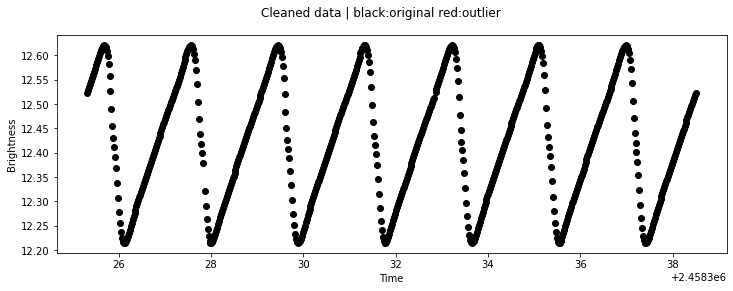

Sigma clipping...


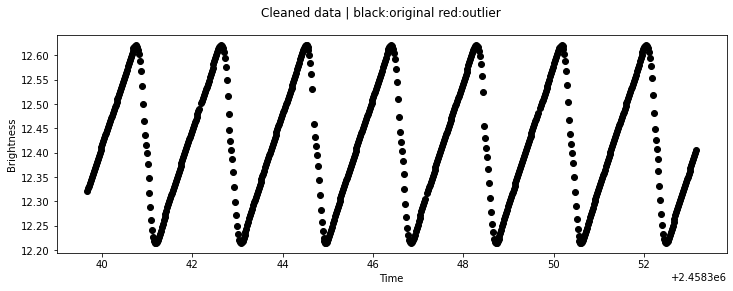

Sigma clipping...


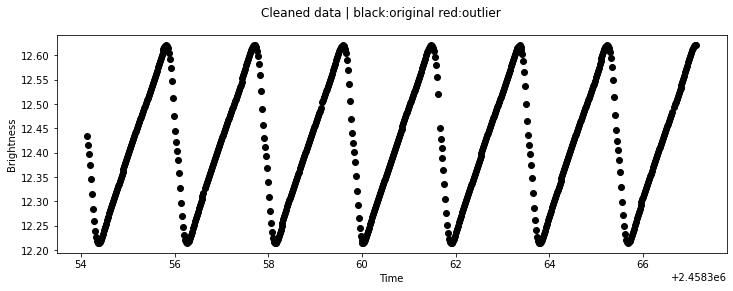

Sigma clipping...


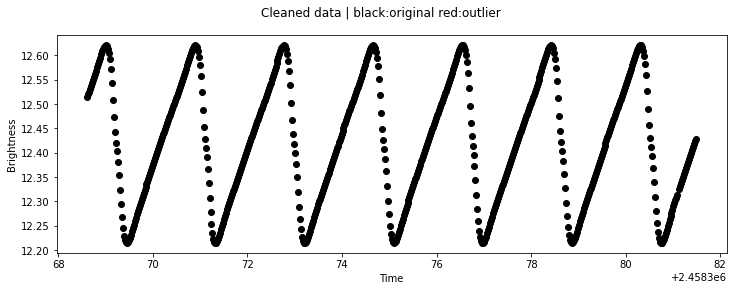

Sigma clipping...


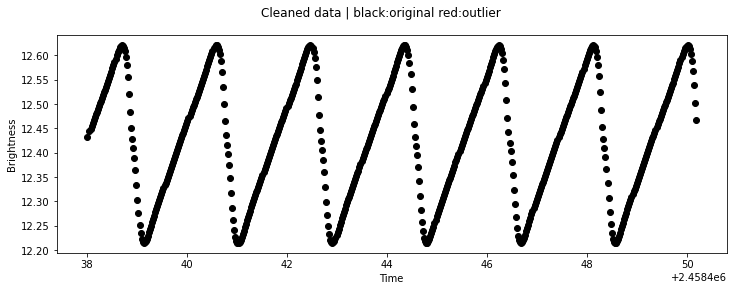

Sigma clipping...


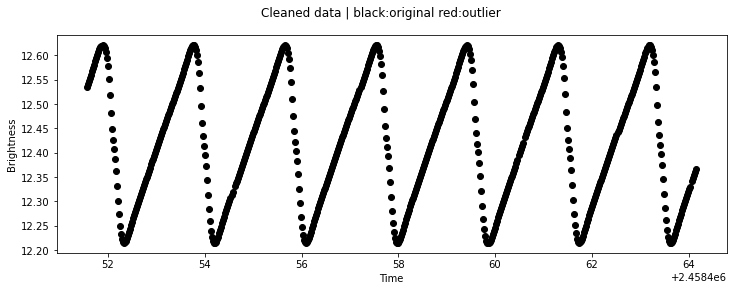

Calculating minima times...


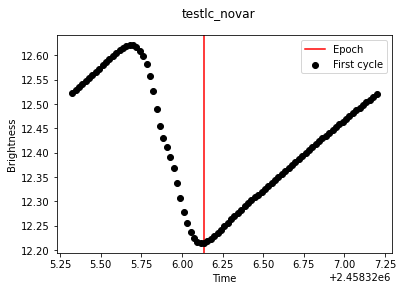

0it [00:00, ?it/s]

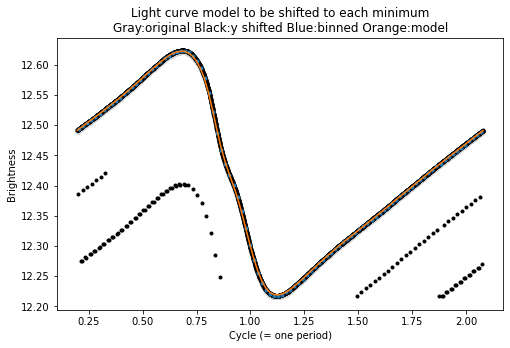

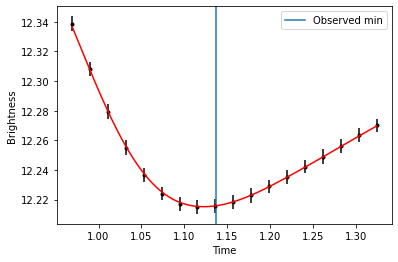

41it [04:31,  6.62s/it]


Calculating O-C...


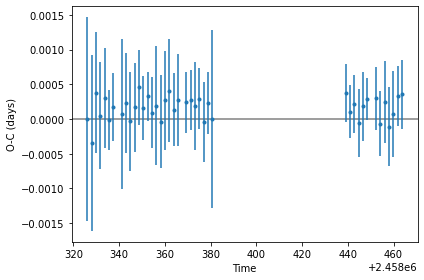

Loading data...
Splitting data by gaps...
Sigma clipping...


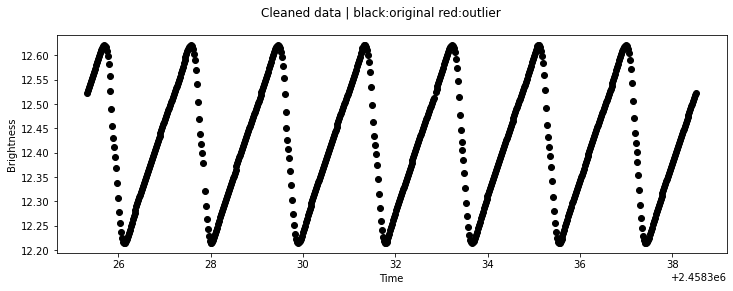

Sigma clipping...


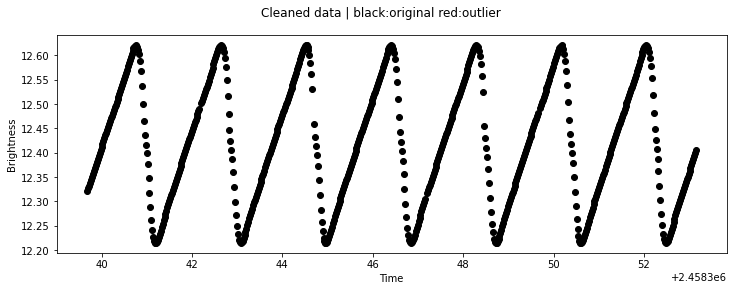

Sigma clipping...


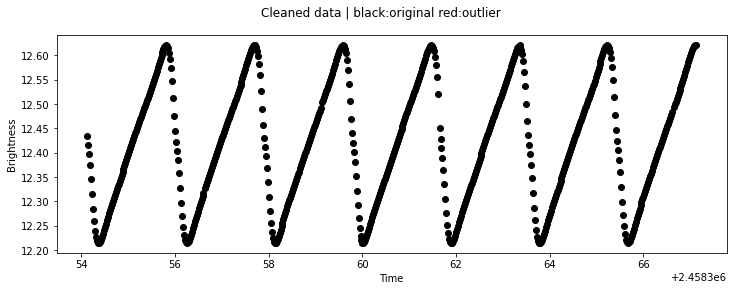

Sigma clipping...


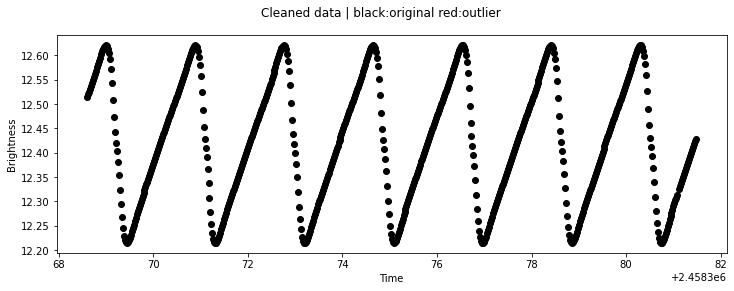

Sigma clipping...


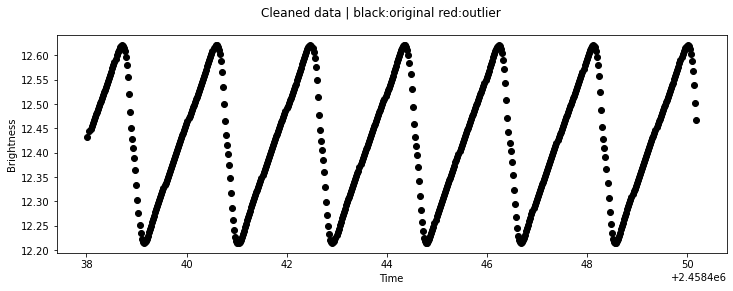

Sigma clipping...


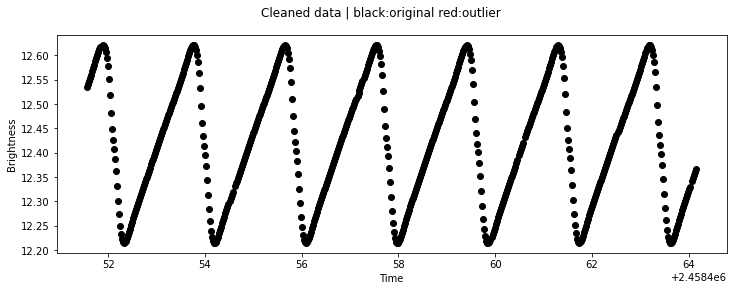

Calculating minima times...


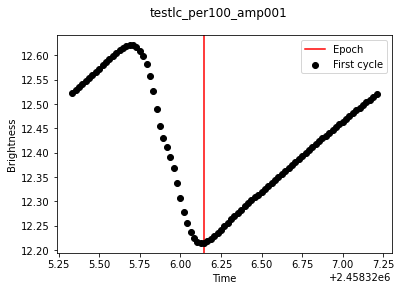

0it [00:00, ?it/s]

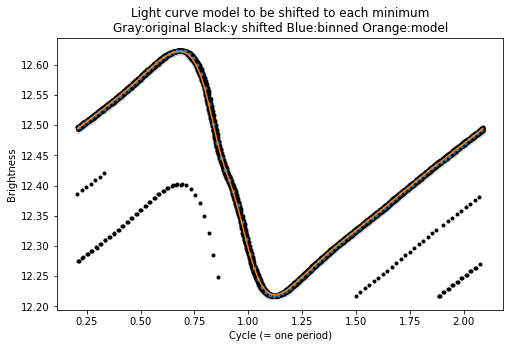

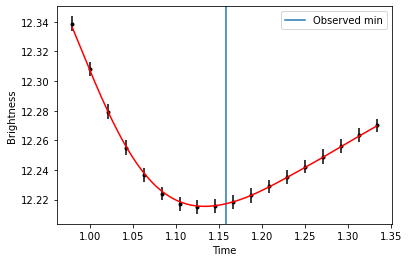

41it [04:18,  6.30s/it]


Calculating O-C...


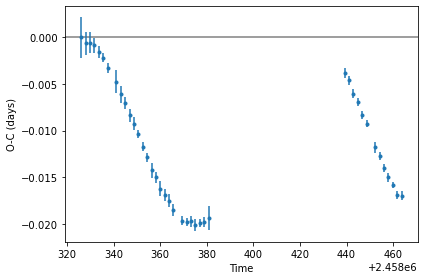

Done


In [4]:
for ii,(name,period) in enumerate(zip(filenames,periods)):
    
    # Load light curves and split by gaps
    lc = load_sectors(name,suffix,usecols=usecols)
    
    # Query VSX for RA DEC and period
    '''
    RA,DEC,period = get_VSX(starname)
    '''
    
    # Convert JD to BJD
    '''
    lc[:,0] = JD2BJD(lc[:,0],RA,DEC)
    '''
    
    lc,splits = split_data_by_gaps(lc)

    # Sigma clip each split and concatenate data
    for i in splits:
        um = np.where(lc[:,-1]==i)[0]
        time = lc[um,0]
        mag = lc[um,1]
        err = lc[um,2]
        time,mag,err = sigma_clipping(time,mag,sigma=10.,err=err,showplot=True)
        if i==0:
            time_final = time
            mag_final  = mag
            err_final  = err
        else:
            time_final = np.hstack((time_final,time))
            mag_final  = np.hstack((mag_final,mag))
            err_final  = np.hstack((err_final,err))

    lc = np.c_[time_final,mag_final,err_final]
    
    # Calculate minimum times
    mintimes,mintimes_err = calculate_mintimes(name,lc,period,
                                               fittype='model', phase_interval=0.1,
                                               order=3, smoothness=1.0,
                                               npools=npools, samplings=100,
                                               showfirst=True, saveplot=True, showplot=False)
    
    # Calculate O-C
    OC,OC_err = calculate_OC(name,period,mintimes,err=mintimes_err,
                             saveplot=True,showplot=True,
                             saveOC=True)

    # Sigma clip O-C and save O-C plot
    '''
    OC_time,OC_value,OC_err = sigma_clipping(OC[:,0],OC[:,1],err=OC_err,
                                            sigma=3,
                                            showplot=False,
                                            kernel='Median')
    
    plt.errorbar(OC_time,OC_value,yerr=OC_err,fmt='o')
    plt.savefig(name+'_OC_sigma.pdf',format='pdf',dpi=100)
    plt.show()
    plt.close('all')
    '''

print('Done')